In [285]:
import tensorflow as tf
import numpy as np

# Nicholas Sugijono / 2602064714
Link Video Penjelasan : https://drive.google.com/drive/folders/1139A_eD4dJnrgwYkwF9gpisIRYYF0p5S?usp=drive_link

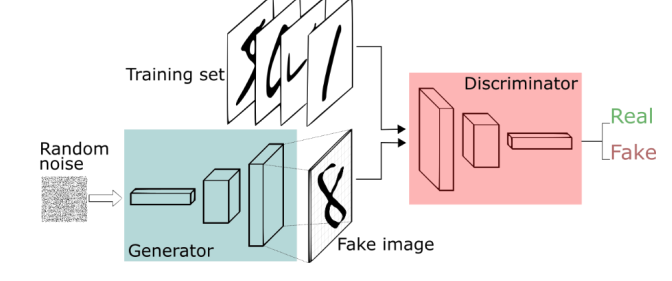

# Importing Dataset

In [286]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist

(data_train, labels_train), (data_test, labels_test) = fashion_mnist.load_data()

data_train = data_train.astype('float32') / 255.
data_test = data_test.astype('float32') / 255.

data = np.concatenate([data_train, data_test], axis=0)
labels = np.concatenate([labels_train, labels_test], axis=0)

filtered_indices = np.where((labels == 0) | (labels == 1))
filtered_data = data[filtered_indices]
filtered_labels = labels[filtered_indices]

print("Filtered data shape:", filtered_data.shape)
print("Filtered labels shape:", filtered_labels.shape)


Filtered data shape: (14000, 28, 28)
Filtered labels shape: (14000,)


In [287]:
data = filtered_data
label = filtered_labels
data.shape

(14000, 28, 28)

In [288]:
total_samples = data.shape[0]
train_size = int(0.8 * total_samples)
valid_size = int(0.2 * total_samples)

In [289]:
train_data = data[:train_size]
test_data = data[train_size:]
train_labels = label[:train_size]
test_labels = label[train_size:]

In [290]:
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (11200, 28, 28)
Test data shape: (2800, 28, 28)


# Data View

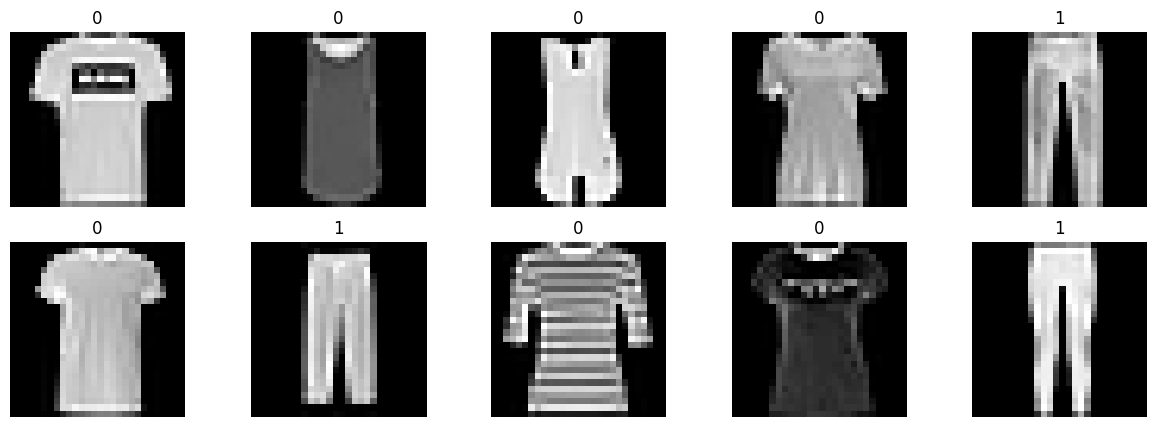

In [291]:
import matplotlib.pyplot as plt

num_images_to_display = 5

fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 5))
for i in range(num_images_to_display):
    #  image
    axes[0, i].imshow(filtered_data[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(filtered_labels[i])

    #  image
    axes[1, i].imshow(filtered_data[i+5], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(filtered_labels[i+5])

plt.show()

In [292]:
train_data = np.expand_dims(train_data, -1)
test_data = np.expand_dims(test_data, -1)

In [293]:
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (11200, 28, 28, 1)
Test data shape: (2800, 28, 28, 1)


# Model

### Generator

In [294]:
from tensorflow.keras import layers

# Generator

def build_generator(latent_dim, num_classes):
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(latent_dim + num_classes,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(28 * 28, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return model

### Discriminator

In [295]:
# Discriminator
def build_discriminator(num_classes):
    img_size = 28 * 28
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(img_size + num_classes,)))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(1024, activation='leaky_relu'))
    model.add(layers.Dense(512, activation='leaky_relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [296]:
latent_dim = 100
num_classes = 2

generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(num_classes)

In [297]:
optimizer_G = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)
optimizer_D = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5)

In [298]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### Training

#### Notes:
combine_noise_and_labels : Menggabungkan vektor noise acak dengan label kelas yang dienkode satu-hot.
combine_images_and_labels : Menggabungkan gambar yang di-flatten dengan label kelas yang dienkode satu-hot.
display_images : Menghasilkan dan menampilkan gambar dari generator menggunakan gabungan noise dan label.
discriminator_training_step : Melatih diskriminator dengan menghitung loss pada gambar asli dan palsu, lalu memperbarui bobot diskriminator.
generator_training_step : Melatih generator dengan menghitung loss pada gambar palsu dan memperbarui bobot generator.
train_step : Mengimplementasikan satu langkah pelatihan untuk GAN.

In [299]:
import tensorflow as tf
from matplotlib import pyplot as plt

def combine_noise_and_labels(noise, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    return tf.concat([noise, label_embedding], axis=1)

def combine_images_and_labels(images, labels, num_classes):
    label_embedding = tf.one_hot(labels, num_classes)
    images_flatten = tf.reshape(images, [images.shape[0], -1])
    return tf.concat([images_flatten, label_embedding], axis=1)

def display_images(generator, noise, labels, epoch, num_examples=5):
    generated_images = generator.predict(combine_noise_and_labels(noise, labels, num_classes), verbose=0)
    generated_images = (generated_images + 1) / 2.0 

    plt.figure(figsize=(10, 2))
    for i in range(num_examples):
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

def discriminator_training_step(real_images_with_labels, fake_images_with_labels):
    with tf.GradientTape() as tape:
        real_output = discriminator(real_images_with_labels, training=True)
        fake_output = discriminator(fake_images_with_labels, training=True)

        d_loss_real = cross_entropy(tf.ones_like(real_output), real_output)
        d_loss_fake = cross_entropy(tf.zeros_like(fake_output), fake_output)
        d_loss = d_loss_real + d_loss_fake

    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    optimizer_D.apply_gradients(zip(grads, discriminator.trainable_variables))

    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

    return d_loss, d_accuracy

def generator_training_step(noise, fake_labels):
    misleading_labels = tf.ones([batch_size, 1])

    with tf.GradientTape() as tape:
        fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes), training=True)
        fake_output = discriminator(combine_images_and_labels(fake_images, fake_labels, num_classes), training=True)

        g_loss = cross_entropy(misleading_labels, fake_output)

    grads = tape.gradient(g_loss, generator.trainable_variables)
    optimizer_G.apply_gradients(zip(grads, generator.trainable_variables))

    return g_loss

@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])
    fake_labels = tf.random.uniform([batch_size], minval=0, maxval=num_classes, dtype=tf.int32)

    fake_images = generator(combine_noise_and_labels(noise, fake_labels, num_classes))

    combined_labels = tf.concat([tf.cast(real_labels, tf.int32), fake_labels], axis=0)
    combined_images = tf.concat([real_images, fake_images], axis=0)

    # Combine images and labels for discriminator
    real_images_with_labels = combine_images_and_labels(real_images, tf.cast(real_labels, tf.int32), num_classes)
    fake_images_with_labels = combine_images_and_labels(fake_images, fake_labels, num_classes)
    combined_images_with_labels = tf.concat([real_images_with_labels, fake_images_with_labels], axis=0)

    # Discriminator training
    d_loss, d_accuracy = discriminator_training_step(real_images_with_labels, fake_images_with_labels)

    # Generator training
    noise = tf.random.normal([batch_size, latent_dim])
    g_loss = generator_training_step(noise, fake_labels)

    return d_loss, g_loss, d_accuracy


In [300]:
# Training loop
def train(dataset, epochs, save_interval=10):
    noise = np.random.normal(0, 1, (5, latent_dim))
    labels = np.random.randint(0, num_classes, 5)
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            d_loss, g_loss, d_acc = train_step(image_batch, label_batch)

        print(f'Epoch {epoch+1}, D Loss: {d_loss.numpy()},D Acc: {d_acc.numpy()} G Loss: {g_loss.numpy()}')

        if (epoch + 1) % save_interval == 0:
            display_images(generator, noise, labels, epoch + 1)

Fungsi train menjalankan loop pelatihan untuk model GAN, di mana:

Setiap epoch, model dilatih menggunakan batch gambar dan label dari dataset.
Setelah setiap epoch, loss dan akurasi dari diskriminator serta loss dari generator dicetak ke konsol.
Pada interval tertentu (misalnya setiap 10 epoch), fungsi display_images dipanggil untuk menampilkan gambar yang dihasilkan oleh generator menggunakan noise dan label yang diinisialisasi sebelumnya.

In [301]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

Epoch 1, D Loss: 0.7593951225280762,D Acc: 0.84375 G Loss: 1.122115135192871
Epoch 2, D Loss: 0.8223035335540771,D Acc: 0.859375 G Loss: 1.3841819763183594
Epoch 3, D Loss: 0.90022873878479,D Acc: 0.90625 G Loss: 0.9245569705963135
Epoch 4, D Loss: 1.2797690629959106,D Acc: 0.6015625 G Loss: 0.9946393966674805
Epoch 5, D Loss: 1.1728878021240234,D Acc: 0.609375 G Loss: 1.3776819705963135
Epoch 6, D Loss: 0.9800658226013184,D Acc: 0.7578125 G Loss: 1.042113184928894
Epoch 7, D Loss: 1.3633040189743042,D Acc: 0.5234375 G Loss: 1.0260810852050781
Epoch 8, D Loss: 1.2855700254440308,D Acc: 0.671875 G Loss: 0.8041524887084961
Epoch 9, D Loss: 1.2515950202941895,D Acc: 0.59375 G Loss: 0.8732028007507324
Epoch 10, D Loss: 1.3690348863601685,D Acc: 0.5703125 G Loss: 0.8105218410491943


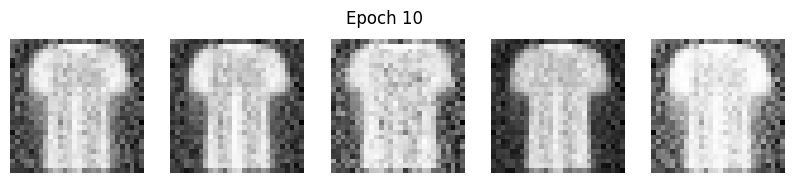

Epoch 11, D Loss: 1.479635238647461,D Acc: 0.46875 G Loss: 0.8271642923355103
Epoch 12, D Loss: 1.3385556936264038,D Acc: 0.53125 G Loss: 0.7373287677764893
Epoch 13, D Loss: 1.349578857421875,D Acc: 0.59375 G Loss: 0.7578372955322266
Epoch 14, D Loss: 1.3684496879577637,D Acc: 0.5390625 G Loss: 0.7805975675582886
Epoch 15, D Loss: 1.3625315427780151,D Acc: 0.5859375 G Loss: 0.7111433148384094
Epoch 16, D Loss: 1.3089027404785156,D Acc: 0.578125 G Loss: 0.6943845152854919
Epoch 17, D Loss: 1.3257372379302979,D Acc: 0.5859375 G Loss: 0.6870896816253662
Epoch 18, D Loss: 1.3964844942092896,D Acc: 0.4453125 G Loss: 0.847074031829834
Epoch 19, D Loss: 1.3959581851959229,D Acc: 0.5546875 G Loss: 0.8244078755378723
Epoch 20, D Loss: 1.2720017433166504,D Acc: 0.640625 G Loss: 0.8027892112731934


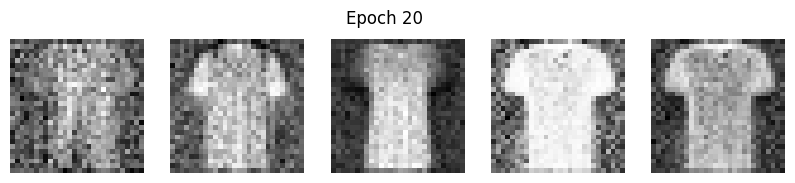

Epoch 21, D Loss: 1.3245139122009277,D Acc: 0.6484375 G Loss: 0.7478018403053284
Epoch 22, D Loss: 1.3628478050231934,D Acc: 0.5625 G Loss: 0.8803644776344299
Epoch 23, D Loss: 1.3671150207519531,D Acc: 0.515625 G Loss: 0.7048566937446594
Epoch 24, D Loss: 1.3831615447998047,D Acc: 0.5625 G Loss: 0.7392956018447876
Epoch 25, D Loss: 1.3603888750076294,D Acc: 0.5703125 G Loss: 0.7491246461868286
Epoch 26, D Loss: 1.4243927001953125,D Acc: 0.484375 G Loss: 0.8262729644775391
Epoch 27, D Loss: 1.6566373109817505,D Acc: 0.5234375 G Loss: 1.542543888092041
Epoch 28, D Loss: 1.379981279373169,D Acc: 0.5078125 G Loss: 0.8372886180877686
Epoch 29, D Loss: 1.5172109603881836,D Acc: 0.546875 G Loss: 0.8398208618164062
Epoch 30, D Loss: 1.3392739295959473,D Acc: 0.6015625 G Loss: 0.7970062494277954


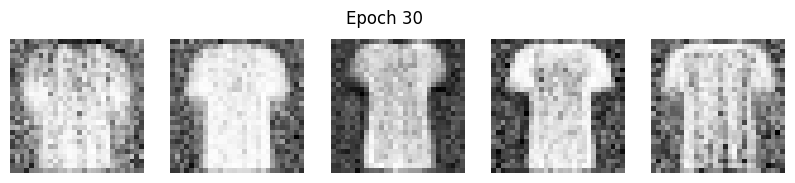

Epoch 31, D Loss: 1.475339412689209,D Acc: 0.5 G Loss: 0.9353534579277039
Epoch 32, D Loss: 1.3585519790649414,D Acc: 0.625 G Loss: 0.7617318630218506
Epoch 33, D Loss: 1.3719943761825562,D Acc: 0.6015625 G Loss: 0.6947810053825378
Epoch 34, D Loss: 1.3038522005081177,D Acc: 0.671875 G Loss: 0.7481867671012878
Epoch 35, D Loss: 1.3077119588851929,D Acc: 0.625 G Loss: 0.8453130722045898
Epoch 36, D Loss: 1.3142130374908447,D Acc: 0.65625 G Loss: 0.7876563668251038
Epoch 37, D Loss: 1.3132771253585815,D Acc: 0.5703125 G Loss: 0.7601827383041382
Epoch 38, D Loss: 1.293491244316101,D Acc: 0.609375 G Loss: 0.9973103404045105
Epoch 39, D Loss: 2.3701062202453613,D Acc: 0.671875 G Loss: 0.3429374694824219
Epoch 40, D Loss: 1.4232633113861084,D Acc: 0.5078125 G Loss: 0.2690015435218811


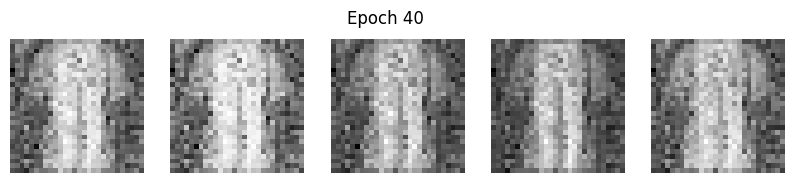

Epoch 41, D Loss: 0.9686383605003357,D Acc: 0.765625 G Loss: 0.7580962181091309
Epoch 42, D Loss: 0.7613067030906677,D Acc: 0.8203125 G Loss: 1.346759557723999
Epoch 43, D Loss: 1.0316252708435059,D Acc: 0.7265625 G Loss: 1.0638203620910645
Epoch 44, D Loss: 1.5378214120864868,D Acc: 0.5859375 G Loss: 0.5972380042076111
Epoch 45, D Loss: 1.4964393377304077,D Acc: 0.359375 G Loss: 0.9595025777816772
Epoch 46, D Loss: 1.4531071186065674,D Acc: 0.5 G Loss: 0.47061482071876526
Epoch 47, D Loss: 1.4162907600402832,D Acc: 0.4375 G Loss: 0.8898120522499084
Epoch 48, D Loss: 1.3482146263122559,D Acc: 0.4609375 G Loss: 0.9938627481460571
Epoch 49, D Loss: 1.3935227394104004,D Acc: 0.5078125 G Loss: 0.7724564075469971
Epoch 50, D Loss: 1.2661042213439941,D Acc: 0.6875 G Loss: 0.8238420486450195


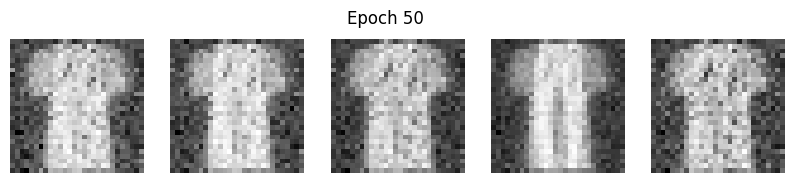

Epoch 51, D Loss: 1.339048147201538,D Acc: 0.53125 G Loss: 0.7081039547920227
Epoch 52, D Loss: 1.4054749011993408,D Acc: 0.4921875 G Loss: 0.7675509452819824
Epoch 53, D Loss: 0.9671916365623474,D Acc: 0.7109375 G Loss: 0.8412472009658813
Epoch 54, D Loss: 0.9868043661117554,D Acc: 0.7734375 G Loss: 0.8788533210754395
Epoch 55, D Loss: 1.244123935699463,D Acc: 0.6484375 G Loss: 1.5108494758605957
Epoch 56, D Loss: 1.4213809967041016,D Acc: 0.5546875 G Loss: 0.8655915856361389
Epoch 57, D Loss: 1.1023560762405396,D Acc: 0.765625 G Loss: 0.8390091061592102
Epoch 58, D Loss: 1.2795805931091309,D Acc: 0.546875 G Loss: 0.735567033290863
Epoch 59, D Loss: 1.3463356494903564,D Acc: 0.5078125 G Loss: 0.9294304847717285
Epoch 60, D Loss: 1.1647210121154785,D Acc: 0.734375 G Loss: 0.9392052292823792


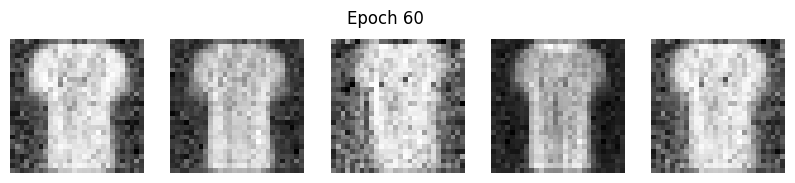

Epoch 61, D Loss: 1.2309186458587646,D Acc: 0.6640625 G Loss: 1.280872106552124
Epoch 62, D Loss: 1.193856120109558,D Acc: 0.671875 G Loss: 0.9604278802871704
Epoch 63, D Loss: 1.4496281147003174,D Acc: 0.59375 G Loss: 1.0541085004806519
Epoch 64, D Loss: 1.2122536897659302,D Acc: 0.6796875 G Loss: 0.7482136487960815
Epoch 65, D Loss: 1.2135237455368042,D Acc: 0.65625 G Loss: 1.004836916923523
Epoch 66, D Loss: 1.4187395572662354,D Acc: 0.546875 G Loss: 0.938904345035553
Epoch 67, D Loss: 1.3410106897354126,D Acc: 0.65625 G Loss: 1.006739854812622
Epoch 68, D Loss: 1.0870236158370972,D Acc: 0.65625 G Loss: 1.0976091623306274
Epoch 69, D Loss: 1.3444709777832031,D Acc: 0.5703125 G Loss: 0.7427567839622498
Epoch 70, D Loss: 1.2728153467178345,D Acc: 0.5703125 G Loss: 0.7968214154243469


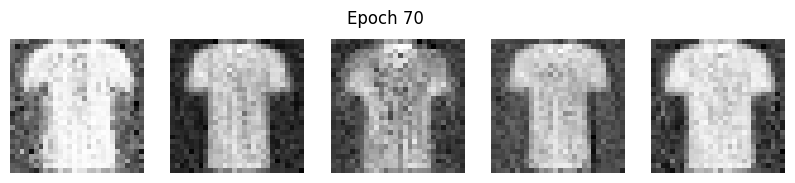

Epoch 71, D Loss: 1.247949242591858,D Acc: 0.6640625 G Loss: 1.0221977233886719
Epoch 72, D Loss: 1.0284104347229004,D Acc: 0.7890625 G Loss: 1.1262941360473633
Epoch 73, D Loss: 1.1676205396652222,D Acc: 0.671875 G Loss: 1.6370816230773926
Epoch 74, D Loss: 1.2400310039520264,D Acc: 0.625 G Loss: 0.8526554107666016
Epoch 75, D Loss: 1.5439704656600952,D Acc: 0.5078125 G Loss: 1.1536028385162354
Epoch 76, D Loss: 1.1733496189117432,D Acc: 0.6640625 G Loss: 0.967211127281189
Epoch 77, D Loss: 1.230248212814331,D Acc: 0.640625 G Loss: 0.8638296127319336
Epoch 78, D Loss: 1.16373872756958,D Acc: 0.6640625 G Loss: 0.8799494504928589
Epoch 79, D Loss: 1.338805913925171,D Acc: 0.53125 G Loss: 0.7648411989212036
Epoch 80, D Loss: 1.253241777420044,D Acc: 0.6484375 G Loss: 1.0874171257019043


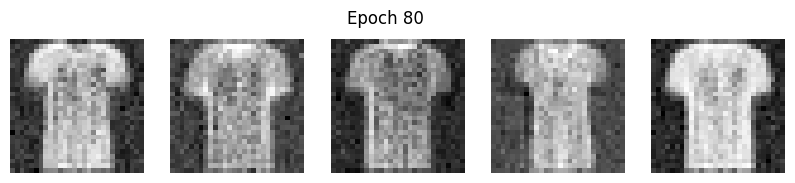

Epoch 81, D Loss: 1.1974568367004395,D Acc: 0.6796875 G Loss: 0.9271465539932251
Epoch 82, D Loss: 1.2399146556854248,D Acc: 0.6640625 G Loss: 0.8638418912887573
Epoch 83, D Loss: 1.1501820087432861,D Acc: 0.6484375 G Loss: 1.0223968029022217
Epoch 84, D Loss: 1.0989131927490234,D Acc: 0.75 G Loss: 1.1949586868286133
Epoch 85, D Loss: 1.4645166397094727,D Acc: 0.5234375 G Loss: 1.0894674062728882
Epoch 86, D Loss: 1.2840111255645752,D Acc: 0.6640625 G Loss: 0.944361686706543
Epoch 87, D Loss: 1.2571284770965576,D Acc: 0.6640625 G Loss: 1.0223742723464966
Epoch 88, D Loss: 1.092835545539856,D Acc: 0.796875 G Loss: 0.9409671425819397
Epoch 89, D Loss: 1.2920401096343994,D Acc: 0.625 G Loss: 0.9244261980056763
Epoch 90, D Loss: 1.2302765846252441,D Acc: 0.6640625 G Loss: 0.9089757800102234


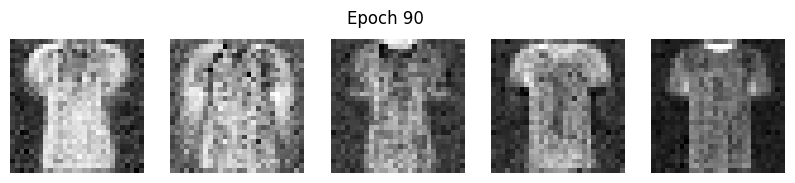

Epoch 91, D Loss: 1.0941766500473022,D Acc: 0.7578125 G Loss: 1.1321852207183838
Epoch 92, D Loss: 1.2164827585220337,D Acc: 0.640625 G Loss: 0.775522768497467
Epoch 93, D Loss: 1.286874532699585,D Acc: 0.6328125 G Loss: 0.8865940570831299
Epoch 94, D Loss: 1.1369127035140991,D Acc: 0.65625 G Loss: 1.3169997930526733
Epoch 95, D Loss: 1.199631929397583,D Acc: 0.6796875 G Loss: 0.850725531578064
Epoch 96, D Loss: 1.3278675079345703,D Acc: 0.6015625 G Loss: 0.8083056211471558
Epoch 97, D Loss: 1.2015515565872192,D Acc: 0.6640625 G Loss: 1.2608773708343506
Epoch 98, D Loss: 1.1511881351470947,D Acc: 0.703125 G Loss: 1.111081600189209
Epoch 99, D Loss: 1.3209056854248047,D Acc: 0.578125 G Loss: 1.9241540431976318
Epoch 100, D Loss: 1.0977158546447754,D Acc: 0.734375 G Loss: 0.9918907880783081


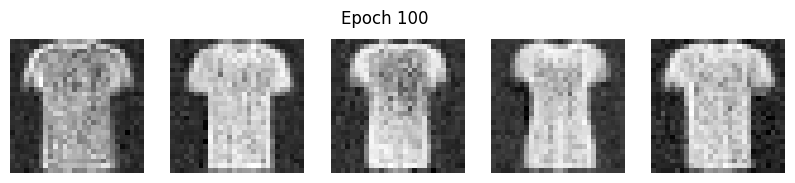

In [302]:
train(train_dataset, epochs=100)

# FID Evaluation

- Mengubah to_rgb : gambar grayscale menjadi RGB.
- get_features : Mengubah ukuran gambar dan melakukan praproses sebelum ekstraksi fitur.
- compute_fid : Menggunakan model InceptionV3 untuk mendapatkan fitur gambar.
- Menghitung skor FID berdasarkan perbedaan statistik antara fitur gambar asli dan palsu.

In [303]:
import tensorflow as tf
import numpy as np
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def to_rgb(images):
    return np.repeat(images, 3, axis=-1)

def get_features(images, model, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        if batch.ndim == 3:
            batch = np.expand_dims(batch, axis=-1)
        batch_rgb = to_rgb(batch)  
        batch_resized = tf.image.resize(batch_rgb, (299, 299))
        batch_preprocessed = preprocess_input(batch_resized)
        batch_features = model.predict(batch_preprocessed)
        features.append(batch_features)
    return np.concatenate(features, axis=0)

def compute_fid(real_features, fake_features):
    mean_real = np.mean(real_features, axis=0)
    cov_real = np.cov(real_features, rowvar=False)
    mean_fake = np.mean(fake_features, axis=0)
    cov_fake = np.cov(fake_features, rowvar=False)

    mean_diff_squared = np.sum((mean_real - mean_fake) ** 2.0)
    cov_mean_sqrt = sqrtm(cov_real.dot(cov_fake))

    if np.iscomplexobj(cov_mean_sqrt):
        cov_mean_sqrt = cov_mean_sqrt.real

    fid_value = mean_diff_squared + np.trace(cov_real + cov_fake - 2.0 * cov_mean_sqrt)
    return fid_value


inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


noise_vector = np.random.normal(0, 1, (data_test.shape[0], latent_dim))
fake_labels = labels_test
fake_images = generator.predict(combine_noise_and_labels(noise_vector, fake_labels, num_classes), verbose=0)


real_features = get_features(data_test, inception_model)
fake_features = get_features(fake_images, inception_model)

fid_score = compute_fid(real_features, fake_features)


1/1 [==============================] - 0s 60ms/step


In [304]:
print(f'FID score: {fid_score}')


FID score: 0.37594176582505445


Dengan nilai FID sebesar 0.3759, kita dapat menyimpulkan bahwa model generatif (generator) yang digunakan dalam pelatihan ini berhasil menghasilkan gambar yang sangat mirip dengan gambar asli dalam ruang fitur yang lebih tinggi. Ini menunjukkan kualitas yang sangat baik dari gambar yang dihasilkan oleh model.